## Object Oriented Implementation of Multivariable Linear Regression using Gradient Descent
#### Goal:- Predict House Prices based on multiple features
#### Dataset:- https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn as skl
import time

### Some EDA for better feature selection

In [38]:
dataset = pd.read_csv('/content/drive/MyDrive/colab datasets/housing.csv')

In [39]:
dataset.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [40]:
dataset.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Categorical features like ocean_proximity can play large roles in the sale price of a house. Let's plot it

<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

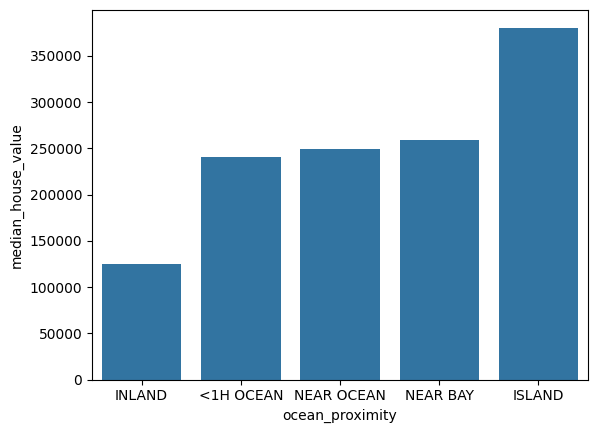

In [41]:
import seaborn as sns
sns.barplot(dataset.groupby("ocean_proximity").mean()["median_house_value"].sort_values())


As we can see this feature shows high correlation. The price increases as we reach closer to the ocean.

So, we can assign the categorical data a numerical value for example
- INLAND - 0
- <1H OCEAN - 1

and so on...

In [42]:
dataset['ocean_proximity'] = dataset['ocean_proximity'].map({'INLAND': 0, '<1H OCEAN': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4})

## Data Imputation
Let's check for na / null type values in the dataset

In [43]:
dataset.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [44]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

In [45]:
dataset.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       536.838857   1425.476744    499.539680       3.870671   
std        419.391878   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        643.250000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  ocean_proximity  
count        20640.000000     20640.000000  
mean        206855.816909         1.034012  
std         115395.615874         0.943948  
min          14999.000000         0.000000  
25%         119600.000000         0.000000  
50%         179700.000000         1.000000  
75%         264725.000000         1.000000  
max         500001.000000         4.000000

## Feature Creation
Features like total_rooms and total_bedrooms would not make much sense. Rather, features like total_rooms_per_household will make a more significant impact in predicitng house prices

In [46]:
dataset["rooms_per_household"] = dataset["total_rooms"] / dataset["households"]
dataset["bedrooms_per_household"] = dataset["total_bedrooms"] / dataset["total_rooms"]
dataset["population_per_household"] = dataset["population"] / dataset["households"]


The target variable median_house_value is capped in this dataset, this can skew our model and may result in a model that undervalues expensive properties. So, for this I will drop all the datapoints that have capped values.

This will limit the range of data on which the model can be used but it will improve the accuracy.

In [47]:
dataset = dataset[dataset['median_house_value'] < dataset['median_house_value'].max()]

## Feature Selection
A plot of all numerical factors against median_house_value to see which features have linear dependence

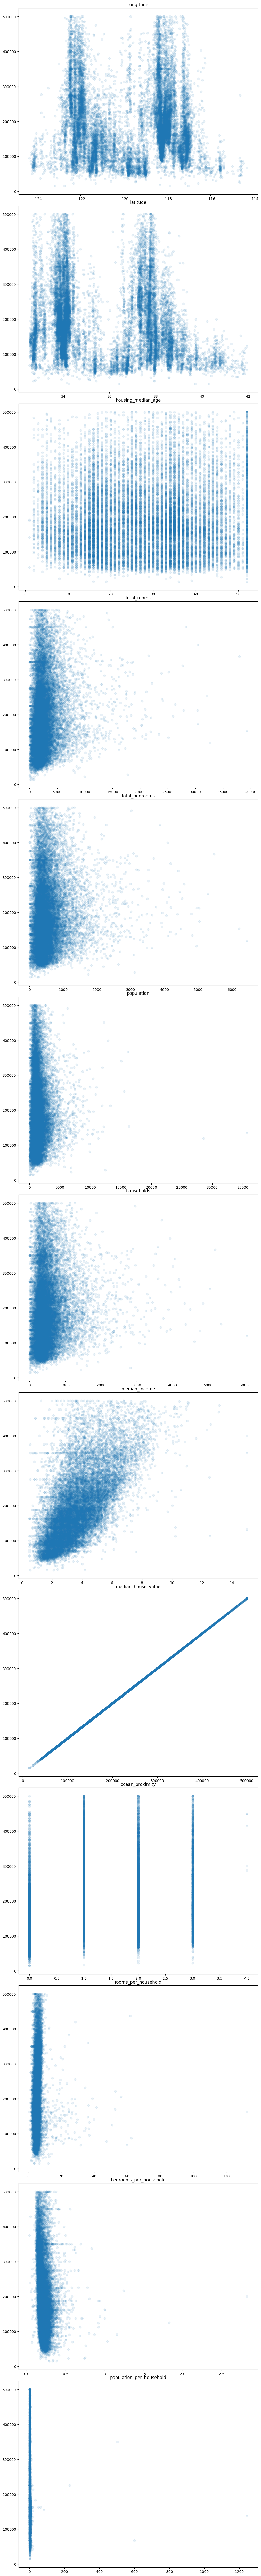

In [48]:
dataset_num = dataset.select_dtypes(include=np.number)
fig, ax = plt.subplots(len(dataset_num.columns), 1, figsize=(10, 100))
fig.tight_layout()
for i in range(len(dataset_num.columns)):
    ax[i].scatter(dataset_num.iloc[:, i], dataset_num['median_house_value'], alpha=0.1)
    ax[i].set_title(dataset_num.columns[i])

## Geographical Plot
Using longitude and latitude, we can have a look at how prices of houses vary depending on their geographical location

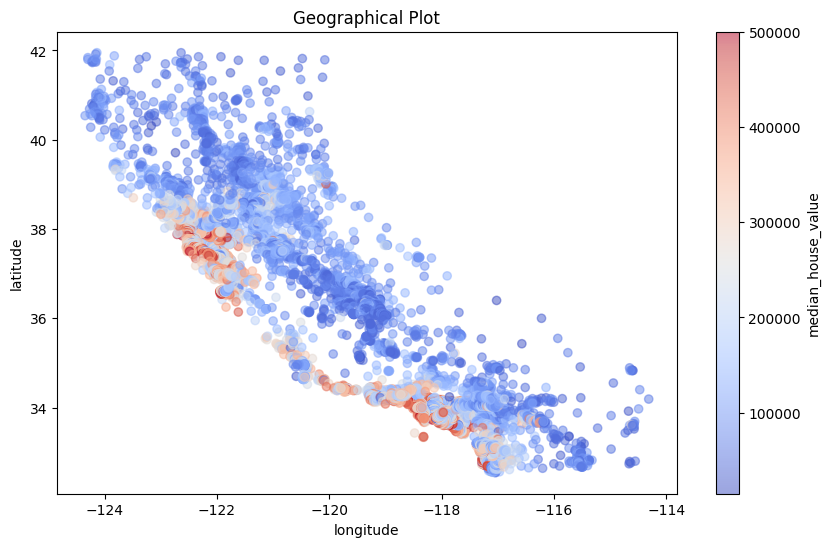

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(dataset['longitude'], dataset['latitude'], c=dataset['median_house_value'], cmap="coolwarm", alpha=0.5)
plt.colorbar(label="median_house_value")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Geographical Plot")
plt.show()

### features with significant linear dependence

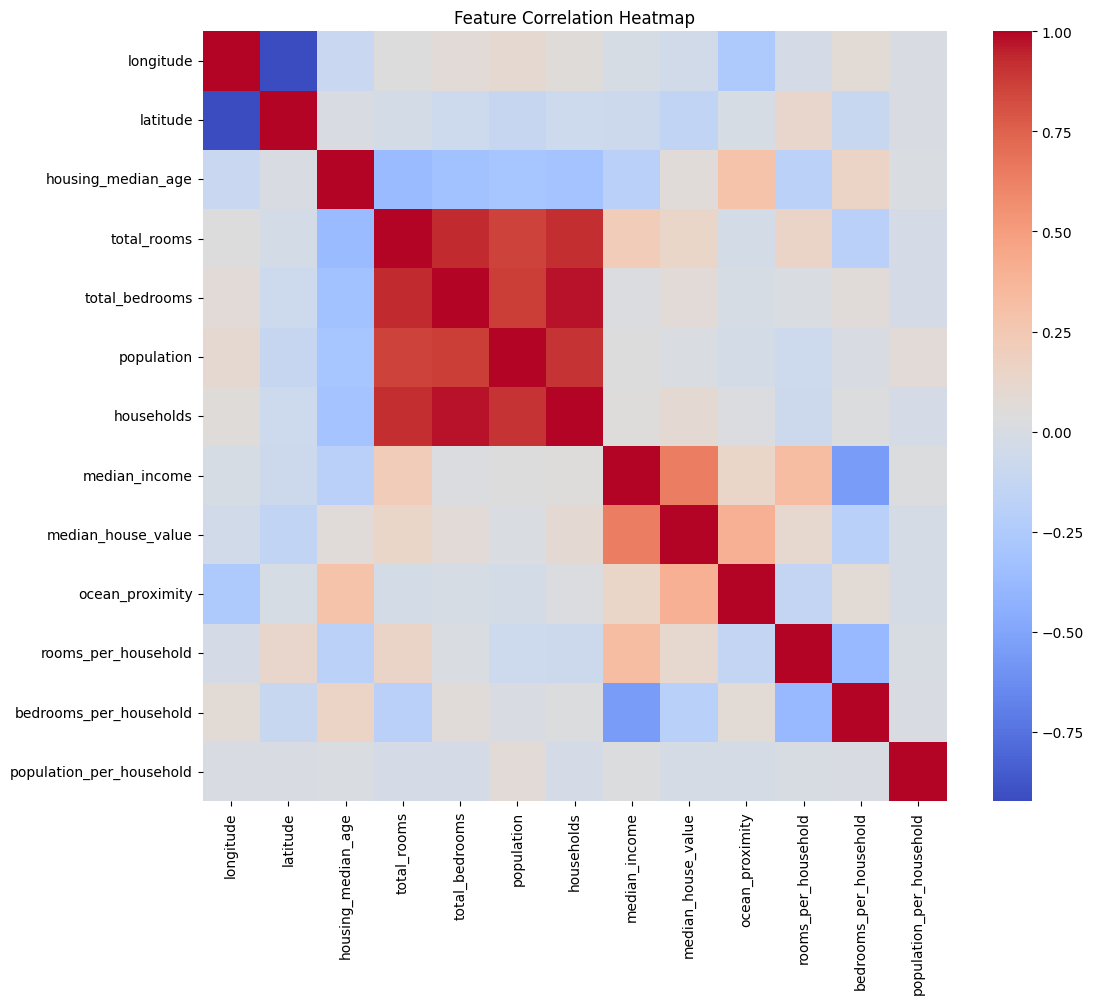

In [50]:
import seaborn as sns

corr = dataset.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [51]:
low_corr_features = ["total_rooms", "total_bedrooms", "population", "households", "population_per_household"]

These features show close to 0 correlation with the target variable and would hence introduce noise in the model.

So, let's drop the

In [52]:
dataset.drop(low_corr_features, axis=1, inplace=True)

## Test train split
Now, I can split the data into testing and training data. I will use sklearn for that

In [53]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.1)

In [54]:
X = train.drop("median_house_value", axis=1).to_numpy().tolist()
y = train["median_house_value"].to_numpy().tolist()

## Now, in multivariable linear regression, it is highly important to perform feature scaling.
#### Here is a non-numpy implementation of commonly used scaling method for gradient descent. (Z-score normalization)

In [55]:
# z-score normalization
# x_norm = ( x - mu ) / sigma
def mean(x):
    total = 0
    for i in x:
        total += i
    return total/len(x)
def std(x):
    total = 0
    mu = mean(x)
    for i in x:
        total += (i-mu)**2
    return (total/len(x))**0.5
def normalize(X):
    for i in range(len(X[0])):
        mu = mean([x[i] for x in X])
        sigma = std([x[i] for x in X])
        for j in range(len(X)):
            X[j][i] = (X[j][i] - mu) / sigma
    return X

X_norm = normalize(X)

# *Part 1* Pure Python Implementation

### Working
Input data is assumed to be X, y where
- X is a python 2d list of shape (s, f) s is the number of samples, and f is the number of features.
- Y is a python list of s elements

A regressor object is created specifying the number of features. Then, gradient descent method is called with appropriate hyperparameters to compute weights and bias.

### Theory


In [56]:
class LinearRegression_pure:
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = [0 for i in range(self.num_features)]
        self.bias = 0
        self.costs = []

    def gradient_descent(self, X, y, alpha, epochs):
        m = len(y)
        for epoch in range(epochs):
            dj_dw = [0 for i in range(self.num_features)]
            dj_db = 0

            for i in range(m):
                f_i = self.predict(X[i])
                dj_db += f_i - y[i]
                for k in range(self.num_features):
                    dj_dw[k] += (f_i - y[i]) * X[i][k]

            dj_db = dj_db / m
            dj_dw = [dj_dw[k] / m for k in range(self.num_features)]

            self.weights = [self.weights[k] - alpha * dj_dw[k] for k in range(self.num_features)]
            self.bias = self.bias - alpha * dj_db
            self.costs.append(self.cost(X, y))

    def cost(self, X, y):
        m = len(y)
        total_cost = 0
        for i in range(m):
            f_i = self.predict(X[i])
            total_cost += (f_i - y[i])**2
        return total_cost / (2 * m)

    def predict(self, x):
        f = 0
        for k in range(self.num_features):
            f += self.weights[k] * x[k]
        f += self.bias
        return f

In [110]:
lg = LinearRegression_pure(len(X_norm[0]))
tic = time.time()
lg.gradient_descent(X_norm, y, 0.01, 1000)
toc = time.time()
pure_time = toc-tic
print(f"Time taken for pure implementation to run:- {pure_time:.2f} seconds")

Time taken for pure implementation to run:- 59.81 seconds


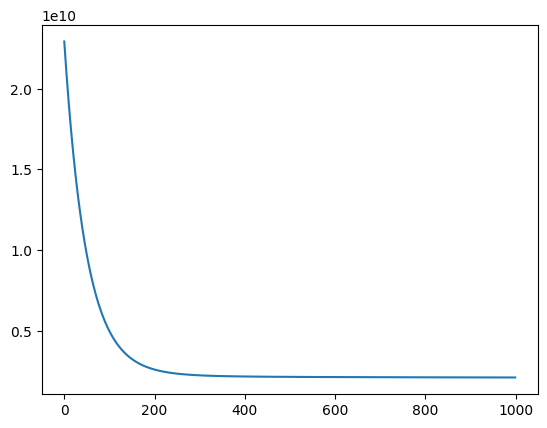

In [58]:
plt.plot(lg.costs)

In [59]:
class LinearRegression_np:
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = np.zeros(self.num_features)
        self.bias = 0
        self.costs = []

    def gradient_descent(self, X, y, alpha, epochs):
        m = len(y)
        for epoch in range(epochs):
            dj_dw = np.zeros(self.num_features)
            dj_db = 0

            f = self.predict(X)
            dj_db = np.mean(f - y)
            dj_dw = np.dot(X.T, (f - y)) / m

            self.weights = self.weights - alpha * dj_dw
            self.bias = self.bias - alpha * dj_db
            self.costs.append(self.cost(X, y))

    def cost(self, X, y):
        m = len(y)
        total_cost = 0
        f = self.predict(X)
        return np.sum((f - y)**2) / (2 * m)

    def predict(self, x):
        return np.dot(x, self.weights) + self.bias

In [112]:
lg_np = LinearRegression_np(len(X[0]))
tic = time.time()
lg_np.gradient_descent(np.array(X_norm), np.array(y), 0.01, 1000)
toc = time.time()
np_time = toc-tic
print(f"Time taken for Numpy implementation to run:- {np_time:.2f} seconds")

Time taken for Numpy implementation to run:- 0.59 seconds


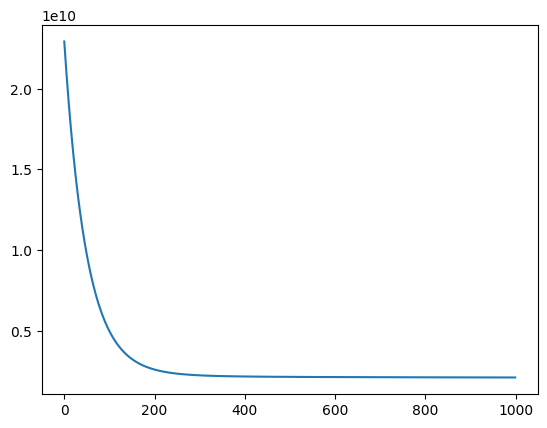

In [61]:
plt.plot(lg_np.costs)

In [62]:
lg_np.weights

array([-21604.95156506, -26313.34381849,   9577.36999408,  66450.07951886,
        20682.64077601,   1081.43380989,  13515.58675603])

In [109]:
from sklearn import linear_model
LinearRegression_sk = linear_model.LinearRegression()
tic = time.time()
LinearRegression_sk.fit(X_norm, y)
toc = time.time()
skl_time = toc-tic
print(f"Time taken for SKLearn implementation to run:- {skl_time:.2f} seconds")

Time taken for SKLearn implementation to run:- 0.04 seconds


In [64]:
LinearRegression_sk.coef_

array([-63898.45482729, -67532.60465432,   8479.45983085,  62930.6856904 ,
        10248.87924955,   4332.41752215,  13082.1679813 ])

## Error Evaluation
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- R-squared (R2 Score)

In [65]:
def mae(pred, X, y):
    n = len(X)
    err = 0
    for i in range(n):
        err += abs(pred[i] - y[i])
    return err / n

def rmse(pred, X, y):
    n = len(X)
    err = 0
    for i in range(n):
        err += (pred[i] - y[i])**2
    return (err / n)**0.5

def r2(pred, X, y):
    n = len(X)
    num_sum = 0
    denom_sum = 0
    y_ = np.mean(y)
    for i in range(n):
        num_sum += (pred[i] - y_)**2
        denom_sum += (y[i] - y_)**2
    return 1 - (num_sum / denom_sum)

In [68]:
r2([lg_np.predict(x) for x in X_norm], X_norm, y)

np.float64(0.4551012677632522)

## Visualization

### Cost function convergence

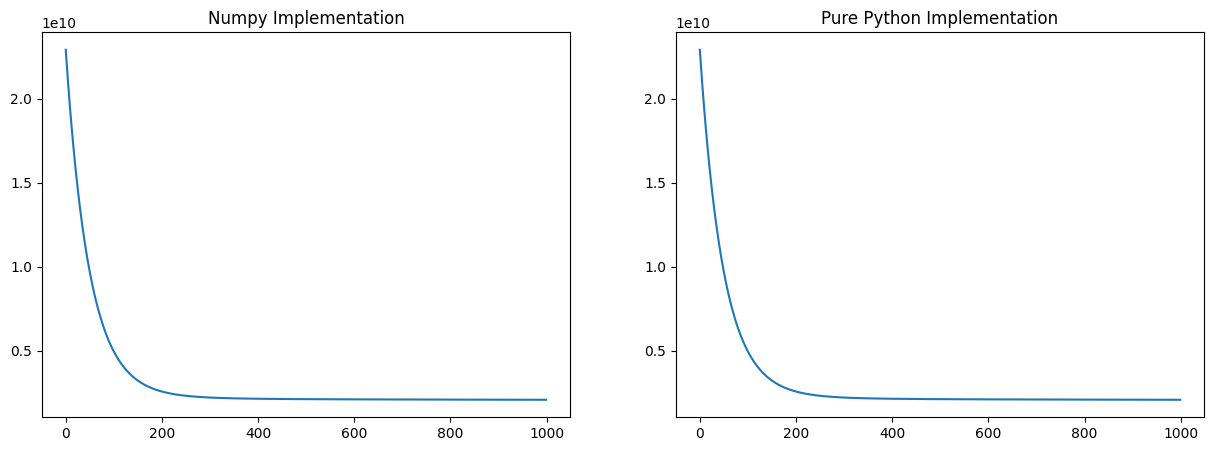

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(lg_np.costs)
ax[0].set_title("Numpy Implementation")
ax[1].plot(lg.costs)
ax[1].set_title("Pure Python Implementation")
fig.show()

In [72]:
ax.shape

(2,)

In [128]:
def get_cost(w, b, X, y):
        m = len(y)
        total_cost = 0
        f = np.dot(X, w) + b
        return np.sum((f - y)**2) / (2 * m)

X_test = normalize(train.drop("median_house_value", axis=1).to_numpy())
y_test = train["median_house_value"].to_numpy()

skl_cost = get_cost(LinearRegression_sk.coef_, LinearRegression_sk.intercept_, np.array(X_norm), np.array(y))
pred_pure = [lg.predict(x) for x in X_test]
pred_np = [lg_np.predict(x) for x in X_test]
pred_skl = LinearRegression_sk.predict(X_test)

metrics = pd.DataFrame({
    "Method":["Pure", "Numpy", "SKLearn"],
    "Time": [pure_time, np_time, skl_time],
    "Final Cost": [lg.costs[-1], lg_np.costs[-1], skl_cost],
    "MAE": [mae(pred_pure, X_test, y), mae(pred_np, X_test, y), mae(pred_skl, X_test, y)],
    "R2": [r2(pred_pure, X_test, y), r2(pred_np, X_test, y), r2(pred_skl, X_test, y)],
    "RMSE": [rmse(pred_pure, X_test, y), rmse(pred_np, X_test, y), rmse(pred_skl, X_test, y)]
    })
metrics.set_index("Method")

Time    Final Cost           MAE        R2          RMSE
Method                                                                
Pure     59.807351  2.094222e+09  47561.903311  0.455101  64718.192108
Numpy     0.592967  2.094222e+09  47561.903311  0.455101  64718.192108
SKLearn   0.036362  2.032040e+09  47169.792572  0.426828  63750.135580

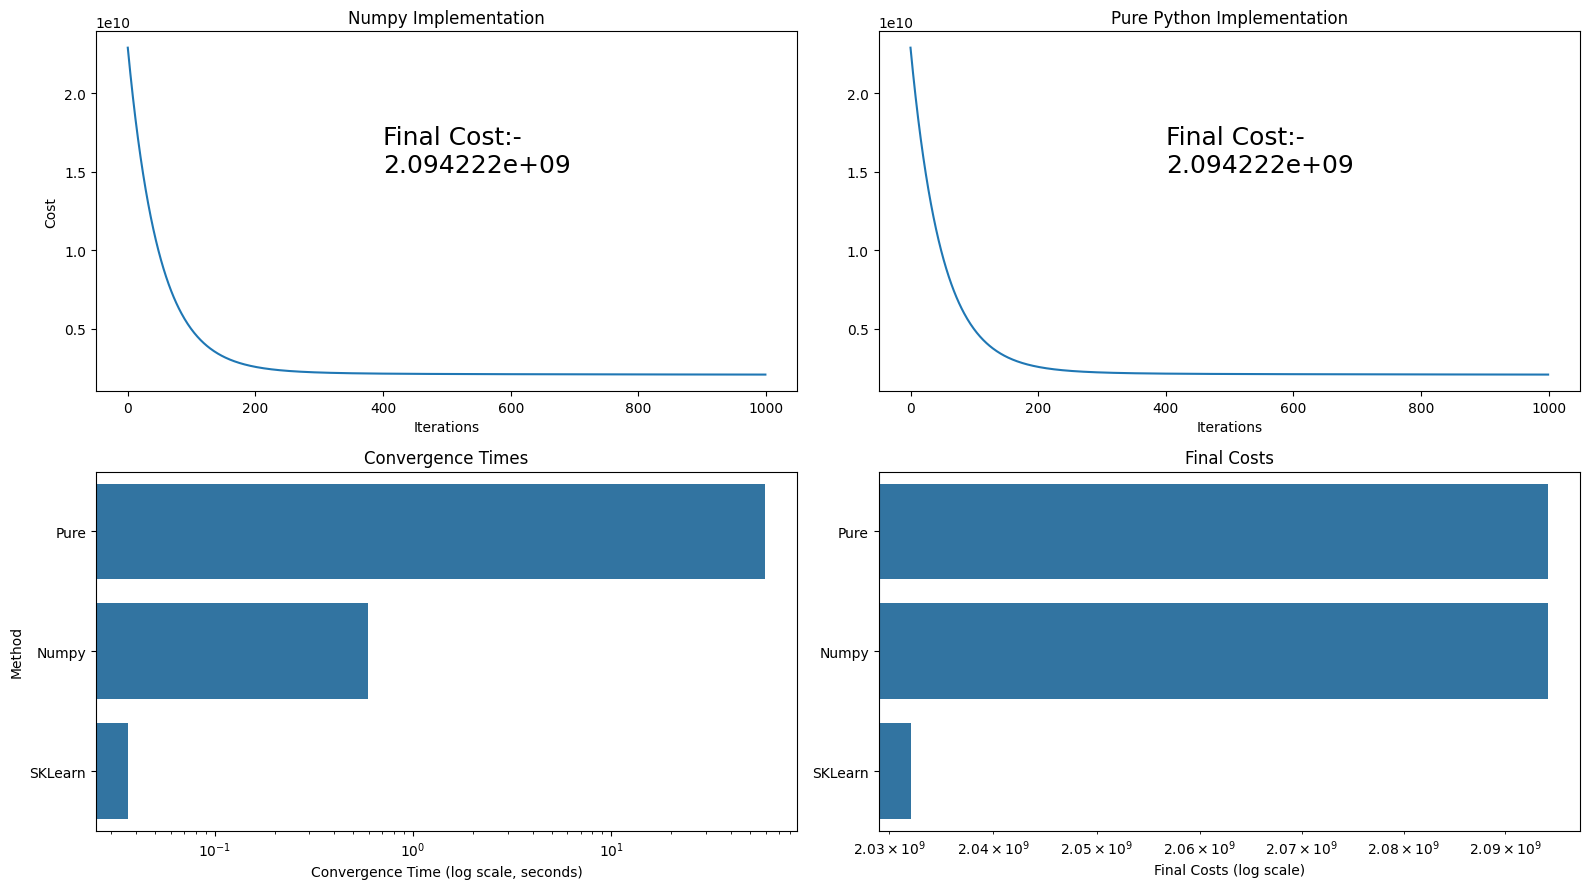

In [127]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.set_title("Numpy Implementation")
ax1.set_ylabel("Cost")
ax1.set_xlabel("Iterations")
sns.lineplot(lg_np.costs, ax=ax1)
ax1.text(400, 1.5e10, f"Final Cost:- \n{lg_np.costs[-1]:e}", fontsize=18)

ax2.set_title("Pure Python Implementation")
ax2.set_xlabel("Iterations")
sns.lineplot(lg.costs, ax=ax2)
ax2.text(400, 1.5e10, f"Final Cost:- \n{lg.costs[-1]:e}", fontsize=18)


ax3.set_title("Convergence Times")
sns.barplot(x="Time", y="Method", data=metrics, ax=ax3)
ax3.set_xscale("log")
ax3.set_xlabel("Convergence Time (log scale, seconds)")

ax4.set_title("Final Costs")
sns.barplot(x='Final Cost', y='Method', data=metrics, ax=ax4)
ax4.set_xscale("log")
ax4.set_xlabel("Final Costs (log scale)")
ax4.set_ylabel("")

plt.tight_layout()
plt.show()